In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_FILE = '/home/mitchell/cgp/CGPExperiments/build/imageGeneData.csv'

In [4]:
df = pd.read_csv(DATA_FILE, sep='|')
print(df.shape)
df.head()

(40000, 4)


,geneName,iterationNum,runtime,params
0,threshold,0,103,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
1,threshold,1,105,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
2,threshold,2,105,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
3,threshold,3,105,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."
4,threshold,4,107,"{""geneName"":""threshold"",""geneTypeId"":""37"",""inp..."


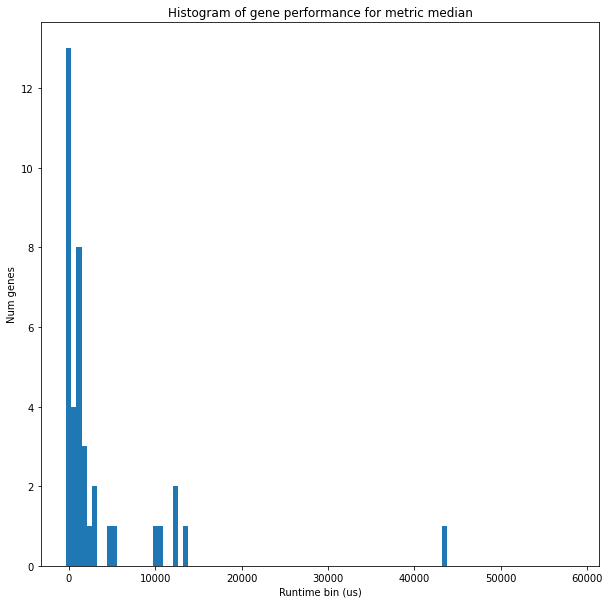

In [43]:
def compute_metric(series, metric_name):
    metric_name = metric_name.lower()
    if (metric_name == 'max'):
        return np.max(series)
    elif (metric_name == 'min'):
        return np.min(series)
    elif ((metric_name == 'mean') or (metric_name == 'avg')):
        return np.mean(series)
    elif (metric_name == 'p95'):
        return np.percentile(series, 95)
    elif (metric_name == 'p99'):
        return np.percentile(series, 99)
    elif (metric_name == 'median'):
        return np.median(series)
    
    raise ValueError('Unknown metric: {0}'.format(metric_name))
    
def plot_perf_report(df, metric):
    genes = list(df['geneName'].unique())
    
    metric_values = {}
    max_metric_value = -1
    for gene in genes:
        filtered = df[df['geneName'] == gene]
        metric_value = compute_metric(filtered['runtime'], metric)
        max_metric_value = max(max_metric_value, metric_value)
        metric_values[gene] = metric_value
    
    step = max_metric_value / 100
    b = np.arange(0, max_metric_value, step)
    m = [metric_values[k] for k in metric_values]
    hist, bb = np.histogram(m, bins=b)
    hist = list(hist) + [0]
    
    fig = plt.figure(figsize=(10,10))
    plt.bar(bb, list(hist), width=max_metric_value / 100)
    plt.xlabel('Runtime bin (us)')
    plt.ylabel('Num genes')
    
    plt.title('Histogram of gene performance for metric {0}'.format(metric))
    
    plt.show()
    
plot_perf_report(df, 'median')

In [46]:
def print_long_times(df, metric, thresh):
    genes = list(df['geneName'].unique())
    
    metric_values = {}
    for gene in genes:
        filtered = df[df['geneName'] == gene]
        metric_value = compute_metric(filtered['runtime'], metric)
        if (metric_value >= thresh):
            metric_values[gene] = metric_value
            
    metric_values = [(k,metric_values[k]) for k in metric_values]
    metric_values.sort(reverse=True, key=lambda x: x[1])
    
    print('Genes with {0} runtime >= {1}:'.format(metric, thresh))
    for metric_value in metric_values:
        print('\t{0}: {1} us'.format(metric_value[0], metric_value[1]))
        
print_long_times(df, 'median', 6000)

Genes with median runtime >= 6000:
	smoothMedian: 58732.0 us
	smoothBilateral: 43922.5 us
	localNormalize: 13567.5 us
	sobelX: 12851.5 us
	sobel: 12521.0 us
	sobelY: 10867.5 us
	exp: 10313.5 us


In [47]:
def generate_gene_summary(df, metric, output_filename):
    with open(output_filename, 'w') as f:
        f.write('gene,runtime\n')
        genes = list(df['geneName'].unique())
        genes.sort()
        
        for gene in genes:
            filtered = df[df['geneName'] == gene]
            metric_value = compute_metric(filtered['runtime'], metric)
            f.write('{0},{1}\n'.format(gene, metric_value))
            
generate_gene_summary(df, 'median', 'summary.csv')